# Regression with computational models and Gaussian process
Author: Mariano Balbi

This notebook is an introduction to the calibration of physics-based simulators with the aid of Gaussian Processes, using a synthetic 1D example. The text has not been proof-read or peer-reviewd and is only to help understand the code and steps of the analysis.

**References:**
1. Rassmussen, C. E. & Williams, C. K. I.: Gaussian Processes for Machine Learning, MIT Press, 2006
2. Gelman, A., et al.: Bayesian Data Analysis, CRC Press, 2013

## Table of Contents
1. [Models & observations](#models_obs)
2. [Model regression with continuous observations](#regression_cont)
   1. [Prediction with computational model only](#prediction_comp)
   2. [Prediction with computational model & inadequacy](#prediction_inad)
3. [Model regression with censored observations](#regression_censored)
   1. [Prediction with computational model only](#prediction_censores_comp)
   2. [Prediction with computational model & inadequacy](#prediction_censores_inad)
4. [Model regression with continuous and censored data (incompleted)](#regression_cont_censored)

This report uses the following Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import lhsmdu
from mcmc import paths_sampler, paths_diagnostics
from minimax_tilting_sampler import TruncatedMVN
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})

----
## Models & observations <a name="models_obs"></a>

In this one-dimensional case, the true (synthetic) process is represented by a modulated harmonic function $f \left(x \right) = x \cdot \sin{ \left( \omega x \right) }$. To predict this, a computational model is available, in the form of a fixed amplitude harmonic function: $ S \left( x \right) = \beta_1 \sin{\left( \beta_2 x \right)}$. 

The parameters $\beta_1$ and $\beta_2$ need to be calibrated with observations (training dataset) of the true process in order to minimize some loss function (e.g. mean-squared error) or to maximize some likelihood function.

In [2]:
# True process
f = lambda x: 3*x**2*np.sin(10*x**2 + 6*x)
# Computational model
computationalModel = lambda x, beta: 3 * x**2 * np.sin( beta*x ) 
# Prediction points
x = np.arange(0,1,0.01).reshape(-1, 1)

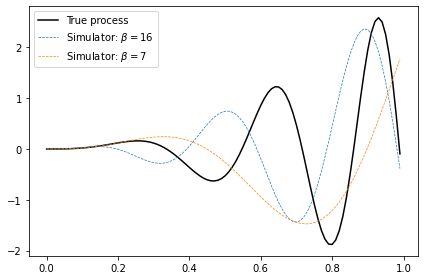

In [3]:
# Plot
fig, ax = plt.subplots( figsize=(6,4) )
o1 = ax.plot( x, f(x), color='k', label='True process' )
o2 = ax.plot( x, computationalModel(x, 16 ), label=r'Simulator: $\beta=16$', 
              linestyle='--', linewidth=0.7 )
o3 = ax.plot( x, computationalModel(x, 7 ), label=r'Simulator: $\beta=7$',
              linestyle='--', linewidth=0.7 )
ax.legend();
fig.tight_layout()
# fig.savefig( '..\\..\\figures_for_paper\\apd_synth_model.png' )

### Observations

The true process can be sampled (observed) not without some measurement or observation error. In this example, we assume that observation errors can be represented by an additive independent random variable, normally distributed with standard deviation, also termed noise-level, $\sigma_n$. This is,
$$
y \left( x_i \right) = f \left( x_i \right) + \varepsilon_i,\ \ \varepsilon_i \sim 
\mathcal{N} \left( 0, \sigma_n^2 \right)
$$

A training dataset is created by sampling random uniform points $x_i \in \left( 0,1 \right)$ with a Latin-hypercube scheme to fairly distribute the samples along the domain, and observations by evaluating those points with the true function $f_i$ with an additive white noise $\varepsilon_i$.

In [4]:
# Training dataset
N = 15 # Training samples
sn = 0.15 # Noise level

# Observations
np.random.seed(25322)
xtrain = np.array(lhsmdu.sample(1,N)).T # Latin hypercube sampling
eps = np.random.normal( size=N, scale=sn ).reshape(-1,1) # Noise samples
ytrain = f( xtrain ) + eps
ztrain = (ytrain > 0)

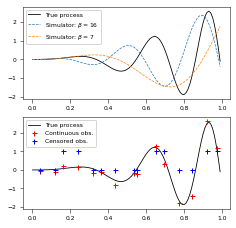

In [6]:
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,8/2.54), ncols=1, nrows=2 )
# Synthetic
o1 = ax[0].plot( x, f(x), color='k', label='True process' )
o2 = ax[0].plot( x, computationalModel(x, 16 ), label=r'Simulator: $\beta=16$', 
              linestyle='--', linewidth=0.7 )
o3 = ax[0].plot( x, computationalModel(x, 7 ), label=r'Simulator: $\beta=7$',
              linestyle='--', linewidth=0.7 )
ax[0].legend( loc='best' );
# Observations
o1 = ax[1].plot( x, f(x), color='k', label='True process' )
o2 = ax[1].plot( xtrain, ytrain, 'r+', label='Continuous obs.', ms=5 )
o3 = ax[1].plot( xtrain, ztrain, 'b+', label='Censored obs.', ms=5 );
ax[1].legend( loc='best')

fig.tight_layout()
# fig.savefig( '..\\..\\figures_for_paper\\apd_synth_observations.pdf',
#              format='pdf', dpi=300)

----
## Model regression with continuous observations <a name="regression_cont"></a>

Considering a general case that includes the computational model and an inadequacy function, the probabilistic model for the data $y$ is given by,

$$
\mathbf{f} = \mathbf{S} + \mathbf{\delta} \\[2ex]

\mathbf{y} = \mathbf{S} + \mathbf{\delta} + \varepsilon\\[2ex]

\varepsilon \sim \mathcal{N} \left( 0, \sigma_n^2 \mathbf{I} \right)
$$

Where $\delta$ is a set of extra parameters to be calibrated, describing the difference between the true process and the output of the computational model at each of the observed points: $\delta=\left\{ \delta(x_1), \delta(x_2), \ldots\right\}$. 

For simplicity of notation, the coordinate $x$ will be removed of all functions: $f \left( x_i \right)= f_i$. For functions values at a vector of spatial coordinates we use bold notation: $\mathbf{f} = \left[ f_1, f_2, \ldots, f_N \right]$.

The distribution of these new parameters, should be flexible enough to accomodate these discrepancies, capturing the spatial structure of the true process that cannot be captured by the available computational model. For this task, an ideal candidate is to assume a correlated Gaussian structure for the prior of $\delta$, what is typically known as Gaussian Process regression.

$$
\delta \left( \mathbf x \right) \sim \mathcal{GP} \left( \delta | \mathbf{0}, k\left(\mathbf{x}, \mathbf{x} \right) \right)
$$

The kernel family used for this example will be the squared exponential kernel (SEK),
$$ 
k\left(x, x' \right) = \sigma_f^2 \exp{ \left( -\frac{1}{2l^2} \left| x - x' \right|^2 \right) } 
$$

In [7]:
def whitekernel(X1, X2, sn):
    """
    White noise kernel. Diagonal covariance matrix

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        sn: noise (nugget)

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return sn**2 * (sqdist==0)

def SEkernel(X1, X2, t):
    """
    Isotropic squared exponential kernel
    k(x,x') = t[0]^2*exp(-1/2/t[1]^2 |x-x'|^2)

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters
            theta[1]: amplitude
            theta[2]: range

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return t[0] ** 2 * np.exp(-0.5 / t[1] ** 2 * sqdist)

The predictive distribution of the true process $\mathbf{f}$ at new points $\mathbf{x^*}$ is computed as,
$$
p \left( \mathbf{f^*} | \mathbf{y} \right) = \int \int p \left( \mathbf{f^*} | \beta, \delta \right) \cdot p \left( \delta |\mathbf{y} \right) p \left( \beta |\mathbf{y} \right) d\beta d\delta
= \int \hat{p} \left( \mathbf{f^*} | \beta, \mathbf{y} \right) \cdot p \left( \beta |\mathbf{y} \right) d\beta
$$

Where now the predictive distribution of the true process can be obtained by integrating out the inedaquacy function $\delta$. This is,
$$
\hat{p} \left( \mathbf{f^*} | \beta, \mathbf{y} \right) = \int p \left( \mathbf{f^*} | \beta, \delta \right) \cdot p \left( \delta |\mathbf{y} \right) d\delta 
$$

The second term $p \left( \delta |\mathbf{y} \right)$ is the posterior distribution of the inadequacy function at the observed points,

$$
p \left( \mathbf{\delta} | \mathbf{y} \right) \propto \mathcal{N} \left( \mathbf{y} | \mathbf{S} + \mathbf{\delta} , \sigma_n^2 \mathbf{I} \right) \cdot \mathcal{N} \left( \mathbf{f} | \mathbf{0}, K \right)


\propto \mathcal{N} \left( \mathbf{\delta} | \mathbf{C} \sigma_n^{-2}\mathbf{I} \left( \mathbf{y} - \mathbf{S} \right) , K - K \left( K + \sigma_n^2 \mathbf{I} \right)^{-1} K \right)
$$

$$
p \left( \mathbf{\delta} | \mathbf{y} \right) = \mathcal{N} \left( \mathbf{\delta} | K \left( K + \sigma_n^2 \mathbf{I} \right)^{-1} \left( \mathbf{y} - \mathbf{S} \right), K - K \left( K + \sigma_n^2 \mathbf{I} \right)^{-1} K \right)
$$

Where $K$ is the covariance matrix obtained by the kernel $ k \left( x, x'\right)$ at observed coordinates $\mathbf{x}$.


The first term is $p \left( \mathbf{f^*} | \delta, \beta \right)$ is the distribution of the true process unobserved points $\mathbf{x^*}$, given the inadequacy values at observed points.
$$
p \left( \mathbf{f^*}| \delta, \beta \right) = \mathcal{N} \left( \mathbf{f^*} | \mathbf{S^*} + K^* K^{-1} \delta, K^{**} - K^* K^{-1} {K^*}^T \right)
$$

This can be obtained by acknowledging that the joint distribution of $\delta^*$ and $\delta$ is Gaussian.

$$
\begin{bmatrix} \mathbf{f^*} \\ \mathbf{\delta} \end{bmatrix} \sim

 \mathcal{N} \left( \begin{bmatrix} \mathbf{S^*} \\ \mathbf{0} \end{bmatrix},

\begin{bmatrix} K^{**} & {K^*}^T \\ K^* & K \end{bmatrix}

\right)
$$

Where, $K^{**}$ is obtained from $k \left( \mathbf{x^*}, \mathbf{x^*} \right)$ and $K^*$ from $k \left( \mathbf{x}, \mathbf{x^*} \right)$.

Thus, the conditional distribution of new predictions on past observations (predictive distribution) and model parameters is given by,
$$     p\left( \mathbf{f^*} | \mathbf{y}, \beta \right) = \mathcal{N} \left( \mathbf{f^*} | \mathbf{S^*} + K^* \left( K + \sigma_n^2 \mathbf{I} \right)^{-1} \left( \mathbf{y} - \mathbf{S} \right), K^{**} - K^* \left( K + \sigma_n^2 \mathbf{I} \right)^{-1} {K^*}^T \right) $$
---
Another way of getting to this result is through,

$$ 
\begin{bmatrix} \mathbf{y} \\ \mathbf{\mathbf{f^*}} \end{bmatrix} \sim

 \mathcal{N} \left( \begin{bmatrix} \mathbf{S} \\ \mathbf{S^*} \end{bmatrix},

\begin{bmatrix} K + \sigma_n^2 \mathbf{I} & {K^*}^T \\ K^* & K^{**} \end{bmatrix}

\right)
$$

---

In [8]:
def predict( xtest, xtrain, ytrain, computationalModel, 
             beta, sn=1, theta=(0,1) ):
    """
    Computes the mean and covariance matrix of the regression function f
    at xtest points

    Args:
        xtest: Array of m points (m x d)
        xtrain: Array of n points (n x d)
        ytrain: Array of n points (n x 1)
        theta: Kernel parameters
        sn: Noise level

    Returns:
        (m x n) matrix
    """
    
    # Computational model
    S = computationalModel( xtrain, beta )
    Sd = computationalModel( xtest, beta )
    
    # Build covariance matrices
    K = SEkernel( xtrain, xtrain, theta )
    Kd = SEkernel( xtest, xtrain, theta )
    Kdd = SEkernel( xtest, xtest, theta )
    K += whitekernel( xtrain, xtrain, sn ) # noise in training obs

    # Predictive mean and covariance
    inad_mean = Kd.dot( np.linalg.solve( K, ytrain - S ) )
    # inad_mean = np.zeros( [xtest.shape[0],xtest.shape[1]] )
    fcov = Kdd - Kd.dot( np.linalg.solve( K, Kd.T ) )

    return Sd + inad_mean, inad_mean, fcov, Sd

#### Likelihood & inference

Model parameters to be used for prediction, can be inferred from the observations. The parameters distribution given the observed data, i.e. the parameters' posterior distribution, can be obtained by means of the Bayes theorem as,

$$
p \left( \beta, \theta, \sigma_n^2 | \mathbf{y} \right) \propto p \left( \mathbf{y} | \beta, \theta, \sigma_n^2 \right) \cdot p \left( \beta, \theta, \sigma_n^2 \right)
$$

For a nonlinear $S$, like in this case, there is no closed form solution for this posterior distribution. Samples from that distribution, however, can be obtained by numerical methods such as Markov Chain-Monte Carlo. An implementation of an adaptive scheme MCMC is used in this notebook.

In [9]:
class Posterior:
    
    def __init__(self, Likelihood, Prior):
        self.likelihood = Likelihood
        self.prior = Prior
        
    def logpdf(self, beta, t):
        return self.likelihood.logpdf( beta, t ) + self.prior.logpdf( np.hstack([beta,t]) )


The likelihood function $p \left( \mathbf{y} | \beta, \theta, \sigma_n^2 \right)$ describes how well the data is represented by the probabilistic model given a set of the models' parameters, and is defined as the probability of data given the parameters. For the probability model proposed above this is,

$$
p \left( \mathbf{y} | \beta, \theta, \sigma_n^2 \right) = \mathcal{N} \left( \mathbf{S}, K + \sigma_n^2 \mathbf{I} \right)\\[2ex]
$$

In [10]:
class GaussianLikelihood:
    
    def __init__(self, x, y, S, kernel, transform=None):
        '''
        
        Args:
            - x: Spatial coordinates (N x m=1)
            - y: Observations (N x 1)
            - S: computational model ( x -> S(x) )
            - kernel: kernel function for covariance ( params -> cov )
        
        '''
        self.xtrain = x
        self.ytrain = y
        self.S = S
        self.kernel = kernel
        self.transform = transform

    def logpdf(self, beta, t ):
        '''
        Log density of the type N(S,kernel(x,x))
        
        Args:
            - beta: parameters of computational model S
            - t: kernel parameters to build covariance matrix
        '''
        beta_, t_ = beta, t
        if self.transform:
            beta_, t_ = self.transform(beta,t)
        
        logN = st.multivariate_normal.logpdf( self.ytrain.squeeze(), 
                            mean=self.S(self.xtrain, beta_).squeeze(),
                            cov=self.kernel(self.xtrain, self.xtrain, t_),
                            allow_singular=True)
        return logN


The prior distribution $p \left( \beta, \theta, \sigma_n^2 \right)$ of the model's parameters should reflect the modeller's knowledge aside from the observations. In this case, for strictly positive parameters, inference can be done for its logarithm, so that priors can be assumed independent and have the following form,

$$
\beta_1 \sim \mathcal{N} \left( 0, s_1^2 \right),\ 
\beta_2 \sim \mathcal{N} \left( 0, s_2^2 \right),\ 
\log \sigma_n^2 \sim \mathcal{N} \left( 0, s_{n}^2 \right)\\[2ex]
\log \sigma_f^2 \sim \mathcal{N} \left( 0, s_{f}^2 \right),\ 
\log l^2 \sim \mathcal{N} \left( 0, s_l^2 \right)
$$

In [11]:
class Prior:
    '''
    Joint distribution of independent variables
    '''
    def __init__(self, distributions):
        self.distributions = distributions
        
    def logpdf(self,x):
        logp = 0
        for i in range( len(self.distributions) ):
            logp += self.distributions[i].logpdf( x[i] )
        return logp
    
    def rvs(self, size=1):
        r = np.zeros( [len(self.distributions), size] )
        for i in range( len(self.distributions) ):
            r[i] = self.distributions[i].rvs( size=size ).squeeze()
        return r.T

### Prediction with computational model only <a name="prediction_comp"></a>

In this particular case, there is no inadequacy function. The likelihood for parameter inference and the predictive distribution are in this case,

$$
p \left( \mathbf{y} | \beta, \sigma_n^2 \right) = \mathcal{N} \left( \mathbf{S}, \sigma_n^2 \mathbf{I} \right) = \prod_i \mathcal{N} \left( S_i, \sigma_n^2 \right) \\[2ex]
p\left( \mathbf{y^*} | \mathbf{y}, \beta, \sigma_n^2 \right) = \delta \left( \mathbf{y^*} = \mathbf{S^*} \right)
$$

This likelihood can be plotted for a range of $\beta$ values, that in this example, is two-dimensional. The plot below, shows that the likelihood has several local maxima, imlpying that different sets of parameters adjust the data equally well. This is a symptom of the limitations of the computational model in representing the observed data. That is, if the model was structurally coherent with the data, there would be a single set of parameters (e.g. the real ones) that best-fit the noisy data.

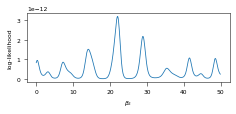

In [12]:
# Likelihood
kernel = lambda X1, X2, t: SEkernel(X1, X2, t[1:]) + whitekernel(X1, X2, t[0])
zeroModel = lambda x, beta: computationalModel( x, beta )
likelihood = GaussianLikelihood( xtrain, ytrain, zeroModel, 
                                 whitekernel )

t = np.log([0.1])
# t = [0.1,3,0.03]
beta = np.arange( 0, 50, 0.1 )
l = np.zeros( beta.size )
for j in range( beta.size ):
    l[j] = np.exp( likelihood.logpdf( beta[j], t ) )
    
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
o1 = ax.plot( beta, l )
ax.set_ylabel('log-likelihood')
ax.set_xlabel(r'$\beta_2$')
plt.tight_layout()
plt.show();   

Since, typically, different maxima correspond to different physical models, it is reasonable for the modeller to pick one of these for model building. This can be done through proper prior specification.

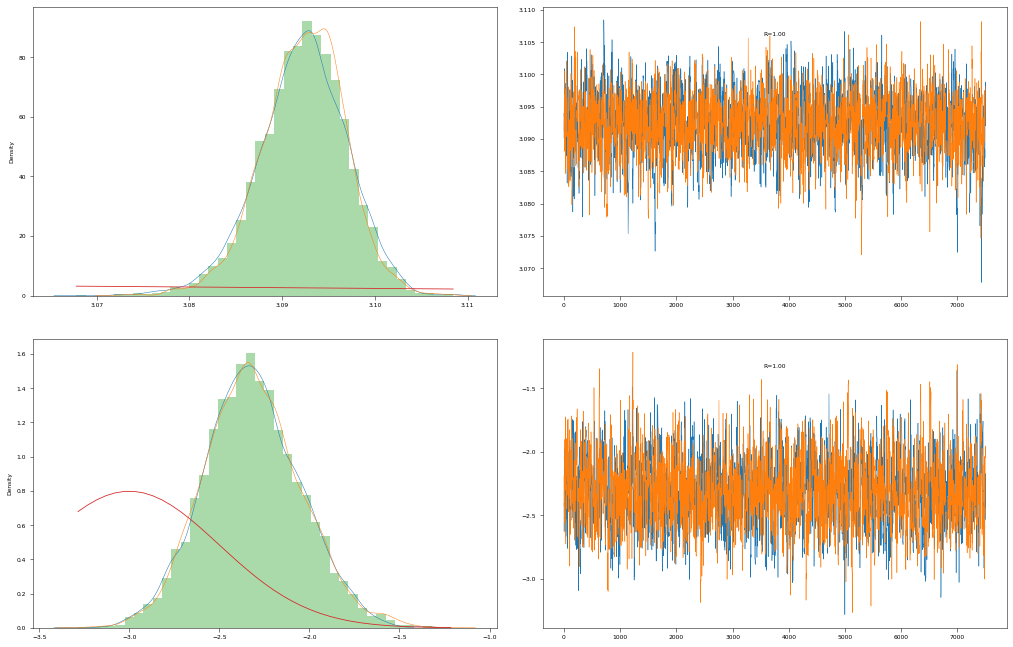

In [13]:
# %%capture
# Prior
logbetaprior = st.norm( loc=3, scale=0.1 )
# logbeta2prior = st.norm( loc=3, scale=1 )
logsn2prior = st.norm( loc=-3, scale=0.5 )
# prior = Prior( [logbeta1prior, logbeta2prior, logsn2prior] )
prior = Prior( [logbetaprior, logsn2prior] )

# Transformation
transform = lambda beta, t: ( np.exp(beta), np.sqrt( np.exp(t)) )

# Likelihood
likelihood = GaussianLikelihood( xtrain, ytrain, computationalModel, 
                                 whitekernel, transform=transform )

# Posterior
posterior = Posterior( likelihood, prior )

# Jump distribution (Gaussian)
# sigmas = np.array([0.2, 0.2, 0.25])
sigmas = np.array([0.1, 0.1])
jump_cov = sigmas**2*np.eye( len(sigmas) )

# Posterior sampling using MCMC
Nsim = 15000
burnin = int(Nsim/2)
Npaths = 2
thin = 1
x0 = prior.rvs( size=Npaths )
Xstack, valid_stack, Xp = paths_sampler( Nsim, Npaths, posterior, x0,
                                         jump_cov, burnin, thin=1,
                                         type='adaptive', 
                                         tune=5000, tune_intvl=500 )

# Convergences diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xp, True, prior );

After sampling from the posterior of the parameters, we can sample from the predictive posterior of the true process given the available observations $p \left( \mathbf{y}^* | \mathbf{y} \right)$. Results are plotted together with the true function and the noisy observations.

In [14]:
# Best parameters
max_index = np.where(valid_stack[:,0]==valid_stack[:,0].max())[0][0]
beta_best, t_best = transform( Xstack[max_index][0], Xstack[max_index][-1] )
fbest = predict( x, xtrain, ytrain, computationalModel, beta_best )[-1]

# Predictive samples
Nsamples = 1000
fsamples = np.zeros( [Nsamples, x.shape[0]] )
indices = np.random.randint(0, Xstack.shape[0], size=Nsamples)
for i in range(Nsamples):
    beta, t = transform( Xstack[indices[i],:][0], Xstack[indices[i],:][-1] )
    fsamples[i] = predict( x, xtrain, ytrain, computationalModel, beta )[-1].squeeze()
conf_bounds = np.quantile( fsamples, (0.1,0.9), axis=0 );

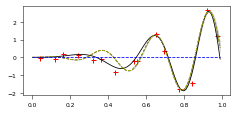

In [15]:
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
# o1 = ax.plot( x[:,0], fsamples.T, color='gray', alpha=0.2 )
o1 = ax.fill_between( x[:,0], conf_bounds[0], conf_bounds[1], alpha=0.4,
                      color='gray', label='90% conf. bounds', linewidth=0)
o2 = ax.plot( xtrain, ytrain, 'r+', label='Data', ms=5 )
o4 = ax.plot( x, f( x ), color='k', linestyle='-', label='True process' )
# o5 = ax.plot( x[:,0], fbest, color='r', 
#               label='best: b1={:3.2f}, b2={:3.2f}'.format(beta_best[0], beta_best[1]) )
o6 = ax.plot( x[:,0], fsamples.mean(0), color='k', linestyle='--', label='Predictive' )
o7 = ax.plot( x[:,0], fsamples.mean(0), color='y', linestyle='--', label='Simulator mean' )
o8 = ax.plot( x[:,0], np.zeros( x.size ), color='b', linestyle='--', label='Inadequacy mean' )
# ax.legend( loc='best', fontsize=8 );
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
fig.tight_layout()
fig.subplots_adjust()
# fig.savefig( '..\\..\\figures_for_paper\\apd_cont_componly.pdf', 
#              format='pdf', dpi=300 )

### Prediction with computational and inadequacy models <a name="prediction_inad"></a>

To understand the role of the inadequacy function, we sample different realizations from its prior distribution $ \delta \sim \mathcal{GP} \left( \mathbf{0}, k\left( x,x'\right) \right) $. The zero-mean implies that, a priori, there is no information on the sign of the bias of the computational model. That is, positive and negative values of the inadequacy funciton are equally likely before including the observations.

The lpots down below, show that the kernel parameter $s_f$ (the marginal variance) is related to the 'amplitude' of the realizations, while the roughness parameter $l$ is related to the frquency content (i.e. the average number of times the function crosses the 0).

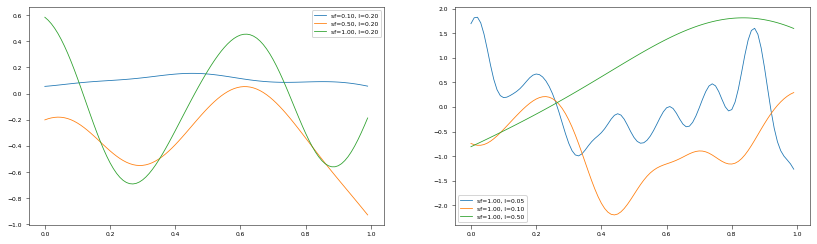

In [16]:
# Generate GP realizations
# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sf = ( 0.1, 0.5, 1 )
l = ( 0.2, 0.2, 0.2 )
for i in range(3):
    params = (sf[i], l[i])
    o = ax[0].plot( x, np.random.multivariate_normal( mean=np.zeros(x.shape[0]),
                                    cov=SEkernel( x, x, params ), size=1 ).T,
                    label='sf={:3.2f}, l={:3.2f}'.format(params[0],params[1]) )
ax[0].legend()

sf = ( 1, 1, 1 )
l = ( 0.05, 0.1, 0.5 )
for i in range(3):
    params = (sf[i], l[i])
    o = ax[1].plot( x, np.random.multivariate_normal( mean=np.zeros(x.shape[0]),
                                    cov=SEkernel( x, x, params ), size=1 ).T,
                    label='sf={:3.2f}, l={:3.2f}'.format(params[0],params[1]) )
ax[1].legend();

In this case, the unidentifiability of the parameters is even more complex since there are two models competing with each other in order to represent the data. For example, for a fixed set of $\beta$ parameters, the inadequacy function can take care of representing the difference between the data and the computational model, no matter how good the latter works.

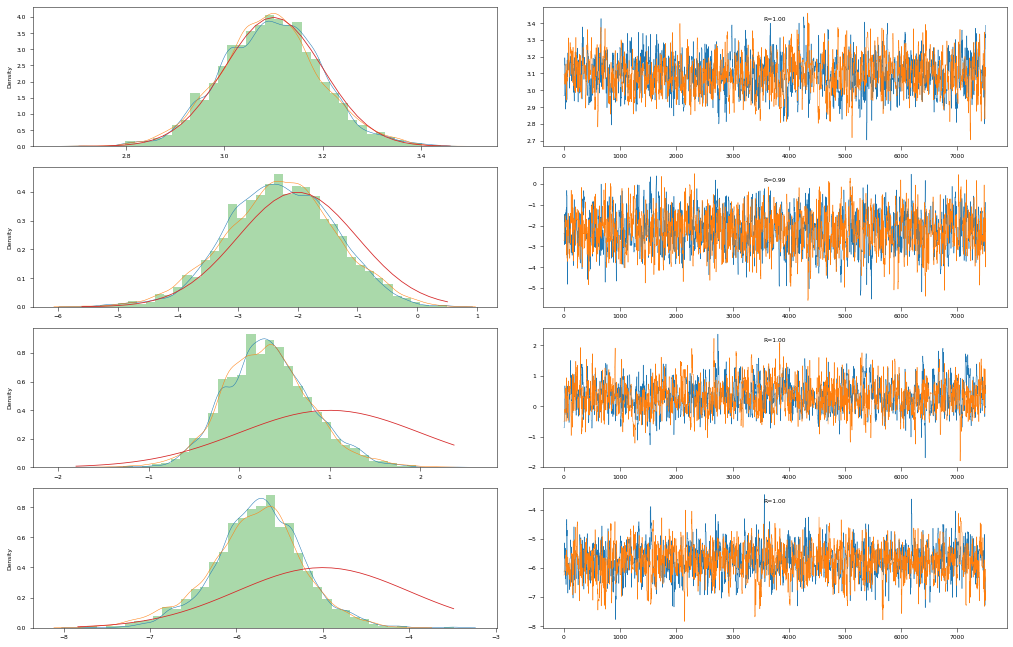

In [17]:
# Prior
# logbeta1prior = st.norm( loc=-10, scale=0.05 )
logbeta2prior = st.norm( loc=3.1, scale=0.1 )
logsn2prior = st.norm( loc=-2, scale=1 )
logsf2_prior = st.norm( loc=1, scale=1 )
logl2_prior = st.norm( loc=-5, scale=1 )
# prior = Prior( [logbeta1prior, logbeta2prior, logsn2prior, logsf2_prior, logl2_prior] )
prior = Prior( [logbeta2prior, logsn2prior, logsf2_prior, logl2_prior] )

# Transformation
transform = lambda beta, t: ( np.exp(beta), np.sqrt(np.exp(t)) )
zeroModel = lambda x, beta: 0*computationalModel( x, beta )

# Likelihood
kernel = lambda X1, X2, t: SEkernel(X1, X2, t[1:]) + whitekernel(X1, X2, t[0])
likelihood = GaussianLikelihood( xtrain, ytrain, zeroModel, 
                                 kernel, transform=transform )

# Posterior
posterior = Posterior( likelihood, prior )

# Jump distribution (Gaussian)
# sigmas = np.array([0.01, 0.1, 0.25, 0.2, 0.2])
sigmas = np.array([0.02, 0.25, 0.2, 0.2])
jump_cov = sigmas**2*np.eye( len(sigmas) )

# Posterior sampling using MCMC
Nsim = 15000
burnin = int(Nsim/2)
Npaths = 2
thin = 1
x0 = prior.rvs( size=Npaths )
Xstack, valid_stack, Xp = paths_sampler( Nsim, Npaths, posterior, x0,
                                         jump_cov, burnin, thin=1,
                                         type='adaptive', 
                                         tune=5000, tune_intvl=500 )

# Convergences diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xp, True, prior );

Predictions of the true process are obtained by sampling from the Gaussian predictive distribution obtained before, for each posterior sample of the model's parameters.

In [18]:
# Best parameters
max_index = np.where(valid_stack[:,0]==valid_stack[:,0].max())[0][0]
beta_best, t_best = transform( Xstack[max_index][0], Xstack[max_index][1:] )
fbest, fmeanbest, _, Sdbest = predict( x, xtrain, ytrain, zeroModel, beta_best,
                                       sn=t_best[0], theta=t_best[1:] )

# Predictive samples
Nsamples = 1000
fsamples = np.zeros( [Nsamples,x.shape[0]] )
inad = np.zeros( [Nsamples,x.shape[0]] )
S = np.zeros( [Nsamples,x.shape[0]] )
indices = np.random.randint(0, Xstack.shape[0], size=Nsamples)
for i in range(Nsamples):
    beta, t =  transform( Xstack[indices[i],:][0], Xstack[indices[i],:][1:] )
    fsample_aux, inad_aux, fcov, S_aux = predict( x, xtrain, ytrain, zeroModel, 
                                                  beta, sn=t[0], theta=t[1:] )
    inad[i] = inad_aux.flatten(); S[i] = S_aux.flatten()
    fsamples[i] = np.random.multivariate_normal( inad[i]+S[i], fcov, size=1 )
conf_bounds = np.quantile( fsamples, (0.1,0.9), axis=0 );

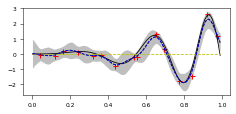

In [19]:
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
# o1 = ax.plot( x[:,0], fsamples.T, color='gray', alpha=0.2 )
o1 = ax.fill_between( x[:,0], conf_bounds[0], conf_bounds[1], alpha=0.5,
                      color='gray', label='90% conf. bounds', linewidth=0)
o2 = ax.plot( xtrain, ytrain, 'r+', label='Data', ms=5 )
o4 = ax.plot( x, f( x ), color='k', linestyle='-', label='True process' )
# o5 = ax.plot( x[:,0], fbest, color='r', 
#               label='best: b1={:3.2f}, b2={:3.2f}'.format(beta_best[0],beta_best[1]) )
o6 = ax.plot( x[:,0], fsamples.mean(0), color='k', linestyle='--', label='Predictive mean' )
o7 = ax.plot( x[:,0], S.mean(0), color='y', linestyle='--', label='Simulator mean' )
o8 = ax.plot( x[:,0], inad.mean(0), color='b', linestyle='--', label='Inadequacy mean' )
# ax.legend( loc='best', fontsize=8 );
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
fig.tight_layout()
fig.subplots_adjust()
# fig.savefig( '..\\..\\figures_for_paper\\apd_cont_inadonly.pdf',
#              format='pdf', dpi=300 );

It can be seen in this case that the fit to the true process is better, and that the inadequacy serves the purpose of correcting the computational model where it needs to.

----
## Model regression with censored data <a name="regression_censored"></a>

In this case, instead of having noisy observations of the true process, we have censored observations of the true process. That is, the data only reflects if the true process is between a given range.

The probabilistic model for the data is given by,

$$
\mathbf{f} = \mathbf{S} + \mathbf{\delta} \\[2ex]

\mathbf{z} = \mathbf{1} \left\{ \mathbf{S} + \mathbf{\delta} + \varepsilon \right\}\\[2ex]

\varepsilon \sim \mathcal{N} \left( 0, \sigma_n^2 \mathbf{I} \right)\\[2ex]

\delta \sim \mathcal{GP} \left( \delta | \mathbf{0}, k\left(\mathbf{x}, \mathbf{x} \right) \right)
$$

The predictive distribution of the true process $\mathbf{f}$ at new points $\mathbf{x^*}$ is computed as,

$$

p \left( \mathbf{f^*} | \mathbf{z} \right) = \int \int p \left( \mathbf{f^*} | \beta, \delta \right) \cdot p \left( \delta |\mathbf{z} \right) p \left( \beta |\mathbf{z} \right) d\beta d\delta
= \int \hat{p} \left( \mathbf{f^*} | \beta, \mathbf{z} \right) \cdot p \left( \beta |\mathbf{z} \right) d\beta
$$

Where now the predictive distribution of the true process can be obtained by integrating out the inedaquacy function $\delta$. This is,

$$
\hat{p} \left( \mathbf{f^*} | \beta, \mathbf{z} \right) = \int p \left( \mathbf{f^*} | \beta, \delta \right) \cdot p \left( \delta |\mathbf{z} \right) d\delta 
$$

The second term $p \left( \delta |\mathbf{z} \right)$ is the posterior distribution of the inadequacy function at the observed points,

$$
p \left( \mathbf{\delta} | \mathbf{z} \right) \propto \prod_i p_i^{y_i} \left( 1-p_i \right)^{1-z_i}  \cdot \mathcal{N} \left( \delta| \mathbf{0}, K \right) = 
\int_{A_i} \mathcal{N} \left( \mathbf{z} | \mathbf{S} + \mathbf{\delta} , K + \sigma_n^2 \mathbf{I} \right) d\mathbf{z}\cdot \mathcal{N} \left( \delta | \mathbf{0}, K \right)
$$

Where $ A_i =  \begin{cases} \left( -\infty, 0\right] & z_i=1\\ \left( 0, \infty \right) & z_i=0 \end{cases} $

In this case the predictive distribution is not Gaussian...

In [20]:
def predictProbit( xtest, xtrain, ytrain, computationalModel, 
                   beta, sn=1, theta=(0,1) ):
    """
    Computes the mean and covariance matrix of the regression function f
    at xtest points

    Args:
        xtest: Array of m points (m x d).
        xtrain: Array of n points (n x d)
        ytrain: Array of n points (n x 1)
        theta: Kernel parameters
        sn: Noise level

    Returns:
        (m x n) matrix
    """
    
    # Build covariance matrices
    K = SEkernel( xtrain, xtrain, theta )
    Kd = SEkernel( xtest, xtrain, theta )
    Kdd = SEkernel( xtest, xtest, theta )
    K += whitekernel( xtrain, xtrain, sn ) # noise in training obs
    
    # Computational model
    S = computationalModel( xtrain, beta )
    Sd = computationalModel( xtest, beta )
    
    # Sample from truncated Normal distribution
    inf = np.zeros( ytrain.shape[0] )
    sup = np.zeros( ytrain.shape[0] )
    for i in range( ytrain.shape[0] ):
        if ytrain[i] == 0:
            inf[i] = -np.inf
            sup[i] = 0
        elif ytrain[i] == 1:
            inf[i] = 0
            sup[i] = np.inf
    tmvn = TruncatedMVN( S.squeeze(), 1*K, inf, sup )
    u = tmvn.sample( 1 )
    
    # Inadequacy sampling
    inad_mean = Kd.dot( np.linalg.solve( K, u - S ) )
    fcov = Kdd - Kd.dot( np.linalg.solve( K, Kd.T ) )
    
    return Sd + inad_mean, inad_mean, fcov, Sd

### Likelihood & inference

The likelihood function in this case is also Gaussian, very similar to the one from the previous model, but now the spatial structure from the inadequacy function is included. That is,
$$
p \left( \mathbf{z} | \beta, \sigma_n^2 \right) = 
\int_{A_N} \ldots \int_{A_1} \mathcal{N} \left( \mathbf{z} | \mathbf{S}, K + \sigma_n^2 \mathbf{I} \right) dz_1 \ldots dz_N
$$
Where $ A_i =  \begin{cases} \left( -\infty, 0\right] & z_i=1\\ \left( 0, \infty \right) & z_i=0 \end{cases} $

In [21]:
class ProbitLikelihood:
    
    def __init__(self, x, y, S, kernel, transform=transform):
        '''
        
        Args:
            - x: Spatial coordinates (N x m=1)
            - y: Observations (N x 1)
            - S: computational model ( x -> S(x) )
            - kernel: kernel function for covariance ( params -> cov )
        
        '''
        self.xtrain = x
        self.ytrain = y
        self.S = S
        self.kernel = kernel
        self.inf = np.zeros( self.ytrain.shape[0] )
        self.sup = np.zeros( self.ytrain.shape[0] )
        self.transform = transform
        # Integration limits
        for i in range( self.ytrain.shape[0] ):
            if self.ytrain[i] == 0:
                self.inf[i] = -np.inf
                self.sup[i] = 0
            elif self.ytrain[i] == 1:
                self.inf[i] = 0
                self.sup[i] = np.inf

    def logpdf(self, beta, t):
        '''
        Log density of the type N(S,kernel(x,x))
        
        Args:
            - beta: parameters of computational model S
            - t: kernel parameters to build covariance matrix
        '''
        beta_, t_ = beta, t
        if self.transform:
            beta_, t_ = self.transform(beta,t)

        p, _ = st.mvn.mvnun( self.inf, self.sup, 
                             self.S(self.xtrain, beta_).squeeze(),
                             self.kernel(self.xtrain, self.xtrain, t_) )
        return np.log(p)

The likelihood for a Binary-Channel observation error is added for completitude. For details on this model, check the paper.

In [22]:
class BCLikelihood:
    
    def __init__(self, x, y, S, kernel, transform=transform):
        '''
        
        Args:
            - x: Spatial coordinates (N x m=1)
            - y: Observations (N x 1)
            - S: computational model ( x -> S(x) )
            - kernel: kernel function for covariance ( params -> cov )
        
        '''
        self.xtrain = x
        self.ytrain = y
        self.S = S
        self.kernel = kernel
        self.inf = np.zeros( self.ytrain.shape[0] )
        self.sup = np.zeros( self.ytrain.shape[0] )
        self.transform = transform
        # Integration limits
        for i in range( self.ytrain.shape[0] ):
            if self.ytrain[i] == 0:
                self.inf[i] = -np.inf
                self.sup[i] = 0
            elif self.ytrain[i] == 1:
                self.inf[i] = 0
                self.sup[i] = np.inf

    def logpdf(self, beta, t):
        '''
        Log density of the type N(S,kernel(x,x))
        
        Args:
            - beta: parameters of computational model S
            - t: kernel parameters to build covariance matrix
        '''
        beta_, t_ = beta, t
        if self.transform:
            beta_, t_ = self.transform(beta,t)
        
        # Computational model
        S = self.S(self.xtrain, beta_)
            
        # Confusion matrix values
        A = np.ma.masked_array( S>0, self.ytrain==0 ).sum() # Correctly predicted flooded (S>0, z=1)
        B = np.ma.masked_array( S>0, self.ytrain==1 ).sum() # Overpredicted (S>0, z=0)
        C = np.ma.masked_array( S<=0, self.ytrain==0 ).sum() # Underpredicted (S=0, z=1)
        D = np.ma.masked_array( S<=0, self.ytrain==1 ).sum() # Correctly predicted dry (S=0, z=0)
        
        # Likelihood
        # alpha = st.norm.cdf( params[2], loc=0, scale=1 )
        # beta = st.norm.cdf( params[3], loc=0, scale=1 )
        logp = A*np.log(t_[0]) + B*np.log(1-t_[0]) + C*np.log(1-t_[1]) + D*np.log(t_[1])
        return logp

The GLUE likelihood is added for completitude. For details on this model, check the paper.

In [23]:
class GLUELikelihood:
    
    def __init__(self, x, y, S):
        '''
        
        Args:
            - x: Spatial coordinates (N x m=1)
            - y: Observations (N x 1)
            - S: computational model ( x -> S(x) )
            - kernel: kernel function for covariance ( params -> cov )
        
        '''
        self.xtrain = x
        self.ytrain = y
        self.S = S

    def F(self, beta):
        '''
        Log density of the type N(S,kernel(x,x))
        
        Args:
            - beta: parameters of computational model S
            - t: kernel parameters to build covariance matrix
        '''
       
        # Computational model
        S = self.S(self.xtrain, beta)
            
        # Confusion matrix values
        A = np.ma.masked_array( S>0, self.ytrain==0 ).sum() # Correctly predicted flooded (S>0, z=1)
        B = np.ma.masked_array( S>0, self.ytrain==1 ).sum() # Overpredicted (S>0, z=0)
        C = np.ma.masked_array( S<=0, self.ytrain==0 ).sum() # Underpredicted (S=0, z=1)
        D = np.ma.masked_array( S<=0, self.ytrain==1 ).sum() # Correctly predicted dry (S=0, z=0)
        
        # Likelihood
        F = (A-B)/(A+B+C)
        return F, A, B, C

### Prediction with computational model only <a name="prediction_censores_comp"></a>

Use only computational model, and no inadequacy term

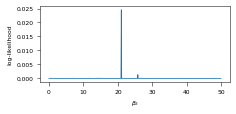

In [24]:
# Likelihood
kernel = lambda X1, X2, t: SEkernel(X1, X2, t[1:]) + whitekernel(X1, X2, t[0])
zeroModel = lambda x, beta: computationalModel( x, beta )
likelihood = BCLikelihood( xtrain, ztrain, zeroModel, whitekernel )

t = np.log([0.9,0.9])
# t = [0.1,3,0.03]
beta = np.arange( 0, 50, 0.1 )
l = np.zeros( beta.size )
for j in range( beta.size ):
    l[j] = np.exp( likelihood.logpdf( beta[j], t ) )
    
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
o1 = ax.plot( beta, l )
ax.set_ylabel('log-likelihood')
ax.set_xlabel(r'$\beta_2$')
plt.tight_layout()
plt.show();   

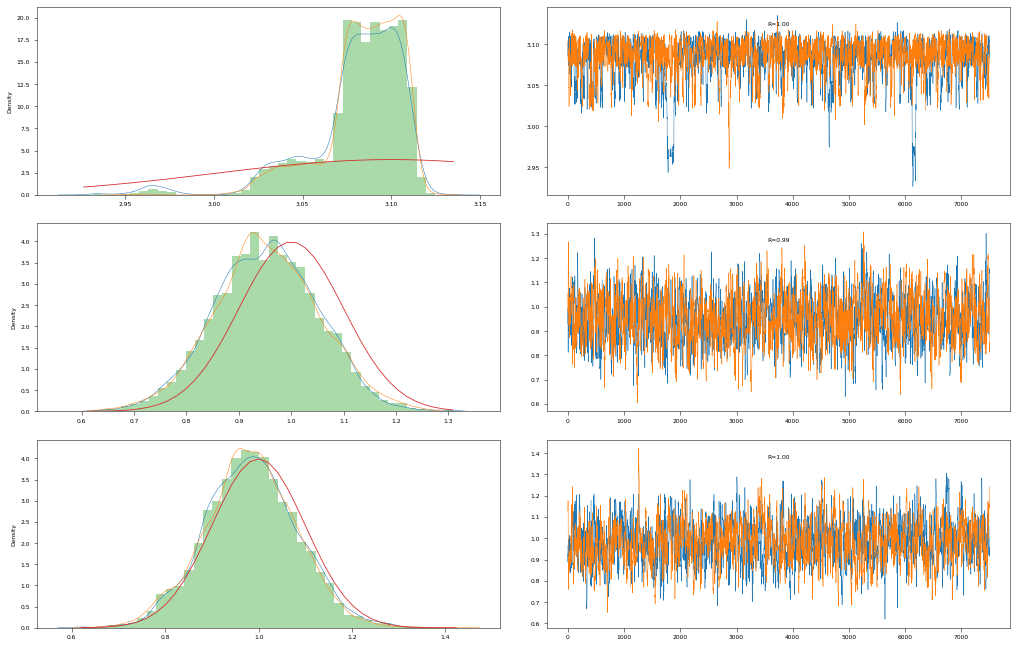

In [25]:
# Prior
# logbeta1prior = st.norm( loc=0, scale=1 )
logbeta2prior = st.norm( loc=3.1, scale=0.1 )
# logsn2prior = st.norm( loc=-2, scale=0.05 )
probitalpha_prior = st.norm( loc=1, scale=0.1 )
probitbeta_prior = st.norm( loc=1, scale=0.1 )
# prior = Prior( [logbeta2prior, logsn2prior] )
prior = Prior( [logbeta2prior, probitalpha_prior, probitbeta_prior] )

# Transformation
# transform = lambda beta, t: ( np.exp(beta), np.sqrt(np.exp(t)) )
transform = lambda beta, t: ( np.exp(beta), st.norm.cdf( t, loc=0, scale=1 ) )

# Likelihood
likelihood = BCLikelihood( xtrain, ztrain, computationalModel, 
                               whitekernel, transform=transform )

# Posterior
posterior = Posterior( likelihood, prior )

# Jump distribution (Gaussian)
sigmas = np.array([0.2, 0.1, 0.1])
# sigmas = np.array([0.05, 0.01])
jump_cov = sigmas**2*np.eye( len(sigmas) )

# Posterior sampling using MCMC
Nsim = 15000
burnin = int(Nsim/2)
Npaths = 2
thin = 1
x0 = prior.rvs( size=Npaths )
Xstack, valid_stack, Xp = paths_sampler( Nsim, Npaths, posterior, x0,
                                         jump_cov, burnin, thin=1,
                                         type='adaptive', 
                                         tune=5000, tune_intvl=500 )

# Convergences diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xp, True, prior );

In [26]:
# GLUE prediction
# Prior
beta2_prior = np.arange( 2.5, 50, 0.01 )
# Likelihood
likelihood = GLUELikelihood( xtrain, ztrain, computationalModel )
# Posterior
F = np.zeros( beta2_prior.size )
for i in range( beta2_prior.size ):
    F[i] = likelihood.F( beta2_prior[i] )[0]
# Translat
F0 = (F - F.min())/(F.max() - F.min())
# thresholding
th = 0.25
F0[F<th] = 0
# Standardize
w = F0/F0.sum()

# Predictions
Nsamples = 1000
fsamples = np.zeros( [Nsamples,x.shape[0]] )
inad = np.zeros( [Nsamples,x.shape[0]] )
S = np.zeros( [Nsamples,x.shape[0]] )
indices = np.random.choice( np.arange(0, beta2_prior.size, 1), size=Nsamples, p=w )
for i in range(Nsamples):
    beta = beta2_prior[ indices[i] ]
    fsamples[i] = computationalModel( x, beta ).squeeze()
    S[i] = fsamples[i]
conf_bounds = np.quantile( fsamples, (0.1,0.9), axis=0 );

In [27]:
# Best parameters
max_index = np.where(valid_stack[:,0]==valid_stack[:,0].max())[0][0]
beta_best, t_best = transform( Xstack[max_index][0], Xstack[max_index][1:] )
fbest, fmeanbest, fcovbest, Sdbest = predictProbit( x, xtrain, ztrain,
                                                    computationalModel,
                                                    beta_best, t_best[0],
                                                    (0,1) )

# Predictive samples
Nsamples = 1000
fsamples = np.zeros( [Nsamples,x.shape[0]] )
inad = np.zeros( [Nsamples,x.shape[0]] )
S = np.zeros( [Nsamples,x.shape[0]] )
indices = np.random.randint(0, Xstack.shape[0], size=Nsamples)
for i in range(Nsamples):
    beta, t =  transform( Xstack[indices[i],:][0], Xstack[indices[i],:][1:] )
    
    fsample_aux, inad_aux, fcov, S_aux = predictProbit( x, xtrain, ztrain,
                                                        computationalModel, beta, 
                                                        t[0], (0,1) )
    inad[i] = inad_aux.flatten(); S[i] = S_aux.flatten()
    fsamples[i] = computationalModel( x, beta ).squeeze()
    # fsamples[i] = np.random.multivariate_normal( fsample_aux.squeeze(),
    #                                              fcov, size=1 )

conf_bounds = np.quantile( fsamples, (0.1,0.9), axis=0 );

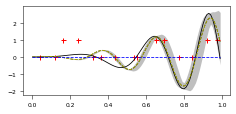

In [28]:
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
# o1 = ax.plot( x[:,0], fsamples.T, color='gray', alpha=0.2 )
o1 = ax.fill_between( x[:,0], conf_bounds[0], conf_bounds[1], alpha=0.5,
                      color='gray', label='90% conf. bounds', linewidth=0)
o2 = ax.plot( xtrain, ztrain, 'r+', label='Data', ms=5 )
o4 = ax.plot( x, f( x ), color='k', linestyle='-', label='True process' )
# o5 = ax.plot( x[:,0], fbest, color='r', 
#               label='best: b1={:3.2f}, b2={:3.2f}'.format(beta_best[0],beta_best[1]) )
o6 = ax.plot( x[:,0], fsamples.mean(0), color='k', linestyle='--', label='Predictive mean' )
o7 = ax.plot( x[:,0], S.mean(0), color='y', linestyle='--', label='Simulator mean' )
o8 = ax.plot( x[:,0], inad.mean(0), color='b', linestyle='--', label='Inadequacy mean' )
# ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
fig.tight_layout()
fig.subplots_adjust()
# fig.savefig( '..\\..\\figures_for_paper\\apd_bin_componly.pdf',
#              format='pdf', dpi=300);
# ax.set_ylim([-3,3]);

### Prediction with computational model & inadequacy models <a name="prediction_censores_inad"></a>

....
....

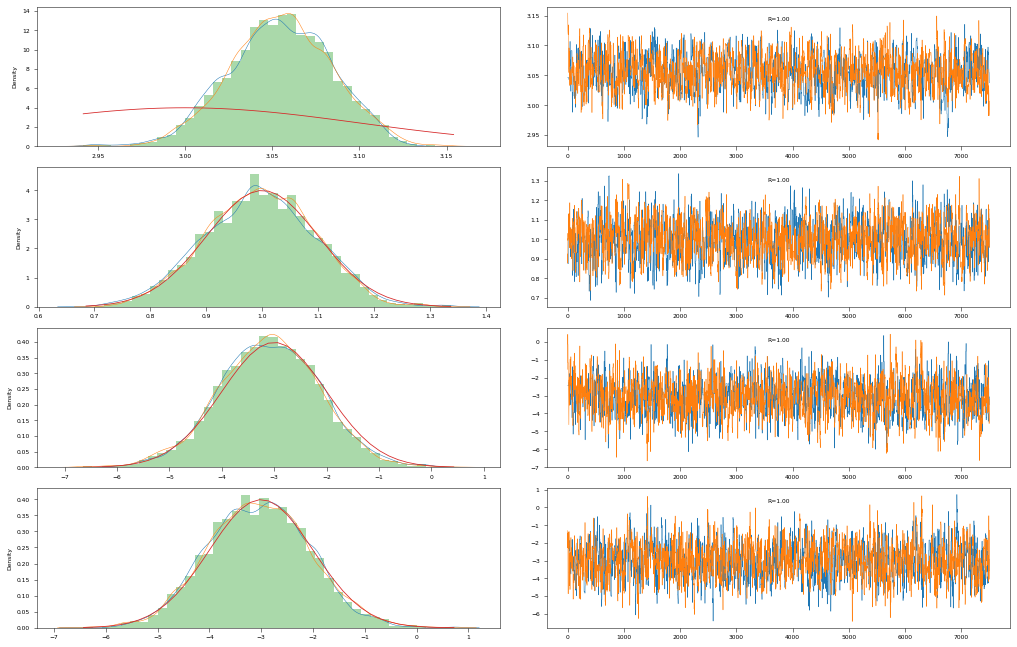

In [29]:
# Prior
# logbeta1prior = st.norm( loc=-6, scale=0.05 )
logbeta2prior = st.norm( loc=3, scale=0.1 )
logsn2prior = st.norm( loc=1, scale=0.1 )
logsf2_prior = st.norm( loc=-3, scale=1 )
logl2_prior = st.norm( loc=-3, scale=1 )
# prior = Prior( [logbeta1prior, logbeta2prior, logsn2prior, logsf2_prior, logl2_prior] )
prior = Prior( [logbeta2prior, logsn2prior, logsf2_prior, logl2_prior] )

# Transformation
transform = lambda beta, t: ( np.exp(beta), np.sqrt(np.exp(t)) )
zeroModel = lambda x, beta: computationalModel( x, beta )

# Likelihood
kernel = lambda X1, X2, t: SEkernel(X1, X2, t[1:]) + whitekernel(X1, X2, t[0])
likelihood = ProbitLikelihood( xtrain, ztrain, zeroModel, 
                               kernel, transform=transform )

# Posterior
posterior = Posterior( likelihood, prior )

# Jump distribution (Gaussian)
# sigmas = np.array([0.02, 0.02, 0.01, 0.01, 0.2])
sigmas = np.array([0.02, 0.01, 0.01, 0.2])
jump_cov = sigmas**2*np.eye( len(sigmas) )

# Posterior sampling using MCMC
Nsim = 15000
burnin = int(Nsim/2)
Npaths = 2
thin = 1
x0 = prior.rvs( size=Npaths )
Xstack, valid_stack, Xp = paths_sampler( Nsim, Npaths, posterior, x0,
                                         jump_cov, burnin, thin=1,
                                         type='adaptive', 
                                         tune=5000, tune_intvl=500 )

# Convergences diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xp, True, prior );

Prediction...

In [30]:
# Best parameters
max_index = np.where(valid_stack[:,0]==valid_stack[:,0].max())[0][0]
beta_best, t_best = transform( Xstack[max_index][0], Xstack[max_index][1:] )
fbest, fmeanbest, fcovbest, Sdbest = predictProbit( x, xtrain, ztrain,
                                                    zeroModel,
                                                    beta_best, t_best[0],
                                                    t_best[1:] )

# Predictive samples
Nsamples = 1000
fsamples = np.zeros( [Nsamples,x.shape[0]] )
inad = np.zeros( [Nsamples,x.shape[0]] )
S = np.zeros( [Nsamples,x.shape[0]] )
indices = np.random.randint(0, Xstack.shape[0], size=Nsamples)
for i in range(Nsamples):
    beta, t =  transform( Xstack[indices[i],:][0], Xstack[indices[i],:][1:] )
    fsample_aux, inad_aux, fcov, S_aux = predictProbit( x, xtrain, ztrain, 
                                                        zeroModel, beta,
                                                        t[0], t[1:] )
    inad[i] = inad_aux.flatten(); S[i] = S_aux.flatten()
    fsamples[i] = np.random.multivariate_normal( fsample_aux.squeeze(),
                                                 fcov, size=1 )

conf_bounds = np.quantile( fsamples, (0.1,0.9), axis=0 );

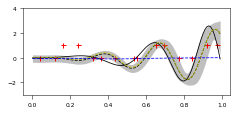

In [34]:
plt.rcParams.update({'font.size': 6, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})
# Plot
fig, ax = plt.subplots( figsize=(8.3/2.54,4/2.54) )
# o0 = ax.plot( x, gp_opt.predict_proba( x )[:, 1], label='scikit')
# o1 = ax.plot( x[:,0], fsamples.T, color='gray', alpha=0.2 )
o1 = ax.fill_between( x[:,0], conf_bounds[0], conf_bounds[1], alpha=0.5,
                      color='gray', label='90% conf. bounds', linewidth=0)
o2 = ax.plot( xtrain, ztrain, 'r+', label='Data', ms=5 )
o4 = ax.plot( x, f( x ), color='k', linestyle='-', label='True process' )
# o5 = ax.plot( x[:,0], fbest, color='r', 
#               label='best: b1={:3.2f}, b2={:3.2f}'.format(beta_best[0],beta_best[1]) )
# o5 = ax.fill_between( x[:,0], fbest[:,0] - 1.64*np.diag(fcovbest),
#                       fbest[:,0] + 1.64*np.diag(fcovbest), alpha=0.5)
o6 = ax.plot( x[:,0], fsamples.mean(0), color='k', linestyle='--', label='Predictive mean' )
o7 = ax.plot( x[:,0], S.mean(0), color='y', linestyle='--', label='Simulator mean' )
o8 = ax.plot( x[:,0], inad.mean(0), color='b', linestyle='--', label='Inadequacy mean' )
# ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
ax.set_ylim([-3,4])
ax.set_yticks([-2,0,2,4])
fig.tight_layout()
fig.subplots_adjust();
fig.savefig( '..\\..\\figures_for_paper\\apd_bin_full_small.pdf',
             format='pdf', dpi=300);

In [ ]:
# Plot  2D probit likelihood
# Transformation
transform = lambda beta, t: ( beta, t )
zeroModel = lambda x, beta: 0*computationalModel( x, beta )

# Likelihood
kernel = lambda X1, X2, t: SEkernel(X1, X2, t[1:]) + whitekernel(X1, X2, t[0])
likelihood = ProbitLikelihood( xtrain, ztrain, zeroModel, 
                               kernel, transform=transform )

# 
beta = [0.1,0.1]
t1 = np.arange( 0.01, 100, 0.1 )
t2 = np.arange( 0.01, 2, 0.1 )
sn = 0.1
X, Y = np.meshgrid( t1, t2 )
Z = np.zeros( X.shape )
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = np.exp( likelihood.logpdf( beta, (sn, X[i,j], Y[i,j]) ) )


In [ ]:
fig, ax = plt.subplots( figsize=(8.3/2.54,8.3/2.54) )
ax.contourf(X,Y,Z)
ax.set_xscale('log')
ax.set_yscale('log')
fig.tight_layout()
plt.show()

----
## Model regression with uncensored and censored data <a name="regression_cont_censored"></a>

In this case, we have a combination of continuous observations and binary observations.

$$
\mathbf{y} = \mathbf{S} + \mathbf{\delta} + \varepsilon\\[2ex]
\mathbf{z} = \mathbf{1} \left\{ \mathbf{S} + \mathbf{\delta} + \varepsilon \right\}\\[2ex]
\mathbf{w} = \begin{bmatrix} \mathbf{y} \\ \mathbf{z} \end{bmatrix}
$$

The likelihood function in this case is also Gaussian, very similar to the one from the previous model, but now the spatial structure from the inadequacy function is included. That is,
$$
p \left( \mathbf{z} | \mathbf{y}, \beta, \sigma_n^2 \right) = \mathcal{N} \left( \mathbf{y} | \mathbf{S}_y, K_{yy} + \sigma_n^2 \mathbf{I} \right) \cdot
\int_{A_N} \ldots \int_{A_1} \mathcal{N} \left( \mathbf{z} | \mathbf{S}, K + \sigma_n^2 \mathbf{I} \right) dz_1 \ldots dz_N
$$
Where $ A_i =  \begin{cases} \left( -\infty, 0\right] & z_i=1\\ \left( 0, \infty \right) & z_i=0 \end{cases} $

UNFINISHED and INCOMPLETE


In [ ]:
class MixtureLikelihood:
    
    def __init__(self, xu, yu, xc, yc, S, kerneluu, kernelcu, kernelcc, transform=transform):
        '''
        
        Args:
            - xu: Spatial coordinates of uncensored observations (N x m=1)
            - yu: Uncensored observations (N x 1)
            - xc: Spatial coordinates of censored observations (N x m=1)
            - yc: Censored observations (N x 1)
            - S: computational model ( x -> S(x) )
            - kernel: kernel function for covariance ( params -> cov )
        
        '''
        self.xutrain = xu
        self.yutrain = yu
        self.xctrain = xc
        self.yctrain = yc
        self.S = S
        self.kerneluu = kerneluu
        self.kernelcu = kernelcu
        self.kernelcc = kernelcc
        self.inf = np.zeros( self.yctrain.shape[0] )
        self.sup = np.zeros( self.yctrain.shape[0] )
        self.transform = transform
        # Integration limits
        for i in range( self.yctrain.shape[0] ):
            if self.yctrain[i] == 0:
                self.inf[i] = -np.inf
                self.sup[i] = 0
            elif self.yctrain[i] == 1:
                self.inf[i] = 0
                self.sup[i] = np.inf

    def logpdf(self, beta, t):
        '''
        Log density of the type N(S,kernel(x,x))
        
        Args:
            - beta: parameters of computational model S
            - t: kernel parameters to build covariance matrix
        '''
        beta_, t_ = beta, t
        if self.transform:
            beta_, t_ = self.transform(beta,t)

        # Covariance matrices
        Kuu = self.kerneluu( self.xutrain, self.xutrain, t_ )
        Kcu = self.kernelcu( self.xctrain, self.xutrain, t_ )
        Kcc = self.kernelcc( self.xctrain, self.xctrain, t_ )
        
        # Marginal means
        Su = self.S(self.xutrain, beta_)
        Sc = self.S(self.xctrain, beta_)
        
        # Conditional likelihood yc|yu               
        pcond, _ = st.mvn.mvnun( self.inf, self.sup, 
                        Sc + Kcu.dot( np.linalg.solve( Kuu, self.yutrain - Su ) ),
                        Kcc - Kcu.dot( np.linalg.solve( Kuu, Kcu.T ) ) )
        # Marginal likelihood of uncernsored observations
        logpmarg = st.multivariate_normal.logpdf( self.yutrain.squeeze(),
                                                  mean=Su.squeeze(), cov=Kuu )
        # Total likelihood
        logp = logpmarg + np.log(pcond)
        
        return logp